In [1]:
!nvidia-sm|

Sat Jun  1 09:15:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 NVL                Off | 00000001:00:00.0 Off |                    0 |
| N/A   29C    P0              60W / 400W |      7MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!pip install Pillow  
!pip install torchvision
!pip install wandb  


In [1]:
import os
import pandas as pd
from datasets import load_dataset
import requests
from PIL import Image
from io import BytesIO


# Function to download an image from a URL and save it locally
def download_image(image_url, save_path):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Check if the request was successful
        image = Image.open(BytesIO(response.content))
        image.save(save_path)
        return True
    except Exception as e:
        print(f"Failed to download {image_url}: {e}")
        return False


# Download the dataset from Hugging Face
dataset = load_dataset('DBQ/Burberry.Product.prices.United.States')


# Convert the Hugging Face dataset to a Pandas DataFrame
df = dataset['train'].to_pandas()


# Create directories to save the dataset and images
dataset_dir = './data/burberry_dataset'
images_dir = os.path.join(dataset_dir, 'images')
os.makedirs(images_dir, exist_ok=True)


# Filter out rows where image download fails
filtered_rows = []
for idx, row in df.iterrows():
    image_url = row['imageurl']
    image_name = f"{row['product_code']}.jpg"
    image_path = os.path.join(images_dir, image_name)
    if download_image(image_url, image_path):
        row['local_image_path'] = image_path
        filtered_rows.append(row)


# Create a new DataFrame with the filtered rows
filtered_df = pd.DataFrame(filtered_rows)


# Save the updated dataset to disk
dataset_path = os.path.join(dataset_dir, 'burberry_dataset.csv')
filtered_df.to_csv(dataset_path, index=False)


print(f"Dataset and images saved to {dataset_dir}")


Generating train split:   0%|          | 0/3038 [00:00<?, ? examples/s]

Failed to download N.A.: Invalid URL 'N.A.': No scheme supplied. Perhaps you meant https://N.A.?
Failed to download N.A.: Invalid URL 'N.A.': No scheme supplied. Perhaps you meant https://N.A.?
Dataset and images saved to ./data/burberry_dataset


In [19]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModelForCausalLM, AutoProcessor
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import pandas as pd
import random
import wandb
import torch.nn.functional as F
import numpy as np
from torchvision.transforms.functional import resize, to_pil_image




torch.manual_seed(3)


# Initialize Weights & Biases
run = wandb.init(project="davidwei-phi3-v")




# Custom Dataset for Burberry Product Prices and Images
class BurberryProductDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, image_size):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.tokenizer.padding_side = 'left'
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = f"<|user|>\n<|image_1|>What is shown in this image?<|end|><|assistant|>\nProduct: {row['title']}, Category: {row['category3_code']}, Full Price: {row['full_price']}<|end|>"
        image_path = row['local_image_path']
        
        # Tokenize text
        encodings = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length)
        
        try:
            # Load and transform image
            image = Image.open(image_path).convert("RGB")
            image = self.image_transform_function(image)
        except (FileNotFoundError, IOError):
            # Skip the sample if the image is not found
            return None
        
        encodings['pixel_values'] = image
        encodings['price'] = row['full_price']
        
        return {key: torch.tensor(val) for key, val in encodings.items()}


    def image_transform_function(self, image):
        image = np.array(image)
        return image






# Load dataset from disk
dataset_path = './data/burberry_dataset/burberry_dataset.csv'
df = pd.read_csv(dataset_path)


# Initialize processor and tokenizer
model_id = "microsoft/Phi-3-vision-128k-instruct"
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
tokenizer = processor.tokenizer


# Split dataset into training and validation sets
train_size = int(0.9 * len(df))
val_size = len(df) - train_size
train_indices, val_indices = random_split(range(len(df)), [train_size, val_size])
train_indices = train_indices.indices
val_indices = val_indices.indices
train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]


# Create dataset and dataloader
train_dataset = BurberryProductDataset(train_df, tokenizer, max_length=512, image_size=128)
val_dataset = BurberryProductDataset(val_df, tokenizer, max_length=512, image_size=128)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)




# Initialize model
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# Training loop
num_epochs = 1
eval_interval = 150  # Evaluate every 'eval_interval' steps
loss_scaling_factor = 1000.0  # Variable to scale the loss by a certain amount
save_dir = './saved_models'
step = 0
accumulation_steps = 64  # Accumulate gradients over this many steps


if not os.path.exists(save_dir):
    os.makedirs(save_dir)


best_val_loss = float('inf')
best_model_path = None


# Select 10 images from the validation set for logging
num_log_samples = 10
log_indices = random.sample(range(len(val_dataset)), num_log_samples)






def extract_price_from_predictions(predictions, tokenizer):
    # Assuming the price is at the end of the text and separated by a space
    predicted_text = tokenizer.decode(predictions[0], skip_special_tokens=True)
    try:
        predicted_price = float(predicted_text.split()[-1].replace(',', ''))
    except ValueError:
        predicted_price = 0.0
    return predicted_price








def evaluate(model, val_loader, device, tokenizer, step, log_indices, max_samples=None, ):
    model.eval()
    total_loss = 0
    total_price_error = 0
    log_images = []
    log_gt_texts = []
    log_pred_texts = []
    table = wandb.Table(columns=["Image", "Ground Truth Text", "Predicted Text"])


    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if max_samples and i >= max_samples:
                break


            if batch is None:  # Skip if the batch is None
                continue


            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = input_ids.clone().detach()
            actual_price = batch['price'].item()


            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                pixel_values=pixel_values, 
                labels=labels
            )
            loss = outputs.loss
            total_loss += loss.item()


            # Calculate price error
            predictions = torch.argmax(outputs.logits, dim=-1)
            predicted_price = extract_price_from_predictions(predictions, tokenizer)
            price_error = abs(predicted_price - actual_price)
            total_price_error += price_error


            # Log images, ground truth texts, and predicted texts
            if i in log_indices:
                log_images.append(pixel_values.cpu().squeeze().numpy())
                log_gt_texts.append(tokenizer.decode(labels[0], skip_special_tokens=True))
                log_pred_texts.append(tokenizer.decode(predictions[0], skip_special_tokens=True))


                # Convert image to PIL format
                pil_img = to_pil_image(resize(torch.from_numpy(log_images[-1]).permute(2, 0, 1), (336, 336))).convert("RGB")
                
                # Add data to the table
                table.add_data(wandb.Image(pil_img), log_gt_texts[-1], log_pred_texts[-1])


                # Log the table incrementally
    
    wandb.log({"Evaluation Results step {}".format(step): table, "Step": step})


    avg_loss = total_loss / (i + 1)  # i+1 to account for the loop index
    avg_price_error = total_price_error / (i + 1)
    model.train()


    return avg_loss, avg_price_error




model.train()
for epoch in range(num_epochs):  # Number of epochs
    total_train_loss = 0
    total_train_price_error = 0
    batch_count = 0


    for batch in train_loader:
        step += 1


        if batch is None:  # Skip if the batch is None
            continue


        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = input_ids.clone().detach()
        actual_price = batch['price'].float().to(device)


        outputs = model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            pixel_values=pixel_values, 
            labels=labels
        )
        loss = outputs.loss
        total_loss = loss
        predictions = torch.argmax(outputs.logits, dim=-1)            
        predicted_price = extract_price_from_predictions(predictions, tokenizer)


        
        total_loss.backward()


        if (step % accumulation_steps) == 0:
            for param in model.parameters():
                if param.grad is not None:
                    param.grad /= accumulation_steps
            optimizer.step()
            optimizer.zero_grad()


        total_train_loss += total_loss.item()
        total_train_price_error += abs(predicted_price - actual_price.item())
        batch_count += 1


        # Log batch loss to wandb
        wandb.log({"Batch Loss": total_loss.item(), "Step": step})


        print(f"Epoch: {epoch}, Step: {step}, Batch Loss: {total_loss.item()}")


        if step % eval_interval == 0:
            val_loss, val_price_error = evaluate(model, val_loader, device, tokenizer=tokenizer, log_indices=log_indices, step=step )
            wandb.log({
                "Validation Loss": val_loss,
                "Validation Price Error (Average)": val_price_error,
                "Step": step
            })
            print(f"Step: {step}, Validation Loss: {val_loss}, Validation Price Error (Normalized): {val_price_error}")


            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_path = os.path.join(save_dir, f"best_model")
                model.save_pretrained(best_model_path, safe_serialization=False)
                tokenizer.save_pretrained(best_model_path)






            avg_train_loss = total_train_loss / batch_count
            avg_train_price_error = total_train_price_error / batch_count
            wandb.log({
                "Epoch": epoch,
                "Average Training Loss": avg_train_loss,
                "Average Training Price Error": avg_train_price_error
            })
            
    print(f"Epoch: {epoch}, Average Training Loss: {avg_train_loss}, Average Training Price Error: {avg_train_price_error}")


    if best_model_path:
        run.log_model(
            path=best_model_path,
            name="phi3-v-burberry",
            aliases=["best"],
        )




    wandb.finish()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0, Step: 1, Batch Loss: 11.79928970336914
Epoch: 0, Step: 2, Batch Loss: 11.847307205200195
Epoch: 0, Step: 3, Batch Loss: 11.846869468688965
Epoch: 0, Step: 4, Batch Loss: 11.832585334777832
Epoch: 0, Step: 5, Batch Loss: 11.901601791381836
Epoch: 0, Step: 6, Batch Loss: 11.851520538330078
Epoch: 0, Step: 7, Batch Loss: 11.837945938110352
Epoch: 0, Step: 8, Batch Loss: 11.759607315063477
Epoch: 0, Step: 9, Batch Loss: 11.84061050415039
Epoch: 0, Step: 10, Batch Loss: 11.6901273727417
Epoch: 0, Step: 11, Batch Loss: 11.843684196472168
Epoch: 0, Step: 12, Batch Loss: 11.66565227508545
Epoch: 0, Step: 13, Batch Loss: 11.819778442382812
Epoch: 0, Step: 14, Batch Loss: 11.870205879211426
Epoch: 0, Step: 15, Batch Loss: 11.808638572692871
Epoch: 0, Step: 16, Batch Loss: 11.656807899475098
Epoch: 0, Step: 17, Batch Loss: 11.825624465942383
Epoch: 0, Step: 18, Batch Loss: 11.754814147949219
Epoch: 0, Step: 19, Batch Loss: 11.570878028869629
Epoch: 0, Step: 20, Batch Loss: 11.8126573562

wandb: Adding directory to artifact (./saved_models/best_model)... 

Epoch: 0, Step: 2730, Batch Loss: 0.10253282636404037
Epoch: 0, Step: 2731, Batch Loss: 0.10441512614488602
Epoch: 0, Step: 2732, Batch Loss: 0.12080122530460358
Epoch: 0, Average Training Loss: 0.6382453013004528, Average Training Price Error: 2377.342259259259


Done. 40.4s


Average Training Loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Average Training Price Error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Batch Loss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Validation Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Price Error (Average),▇█▅▄▃▃▂▂▃▂▂▂▁▁▂▁▂▁
Average Training Loss,0.63825
Average Training Price Error,2377.34226
Batch Loss,0.1208
Epoch,0


wandb: ERROR Control-C detected -- Run data was not synced


wandb: Downloading large artifact davidwei-phi3-v:v0, 7911.12MB. 8 files... 
wandb:   8 of 8 files downloaded.  
Done. 0:0:6.8


Artifact downloaded to: /root/artifacts/phi3-v-burberry:v0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Logged in as Weights & Biases user: davidsajare.
View Weave data at https://wandb.ai/davidsajare/davidwei-phi3-v-test/weave
🍩 https://wandb.ai/davidsajare/davidwei-phi3-v-test/r/call/5e30baee-2e57-4dbf-8f7f-9c5051197045
Predicted Text: 1. The price for size 6.5 is $115.00. 2. The good is Nike Dunk Low DD1503-101 Women's White Black Leather Sneaker Shoes Size 9 PRO43.
Image Data URL: 

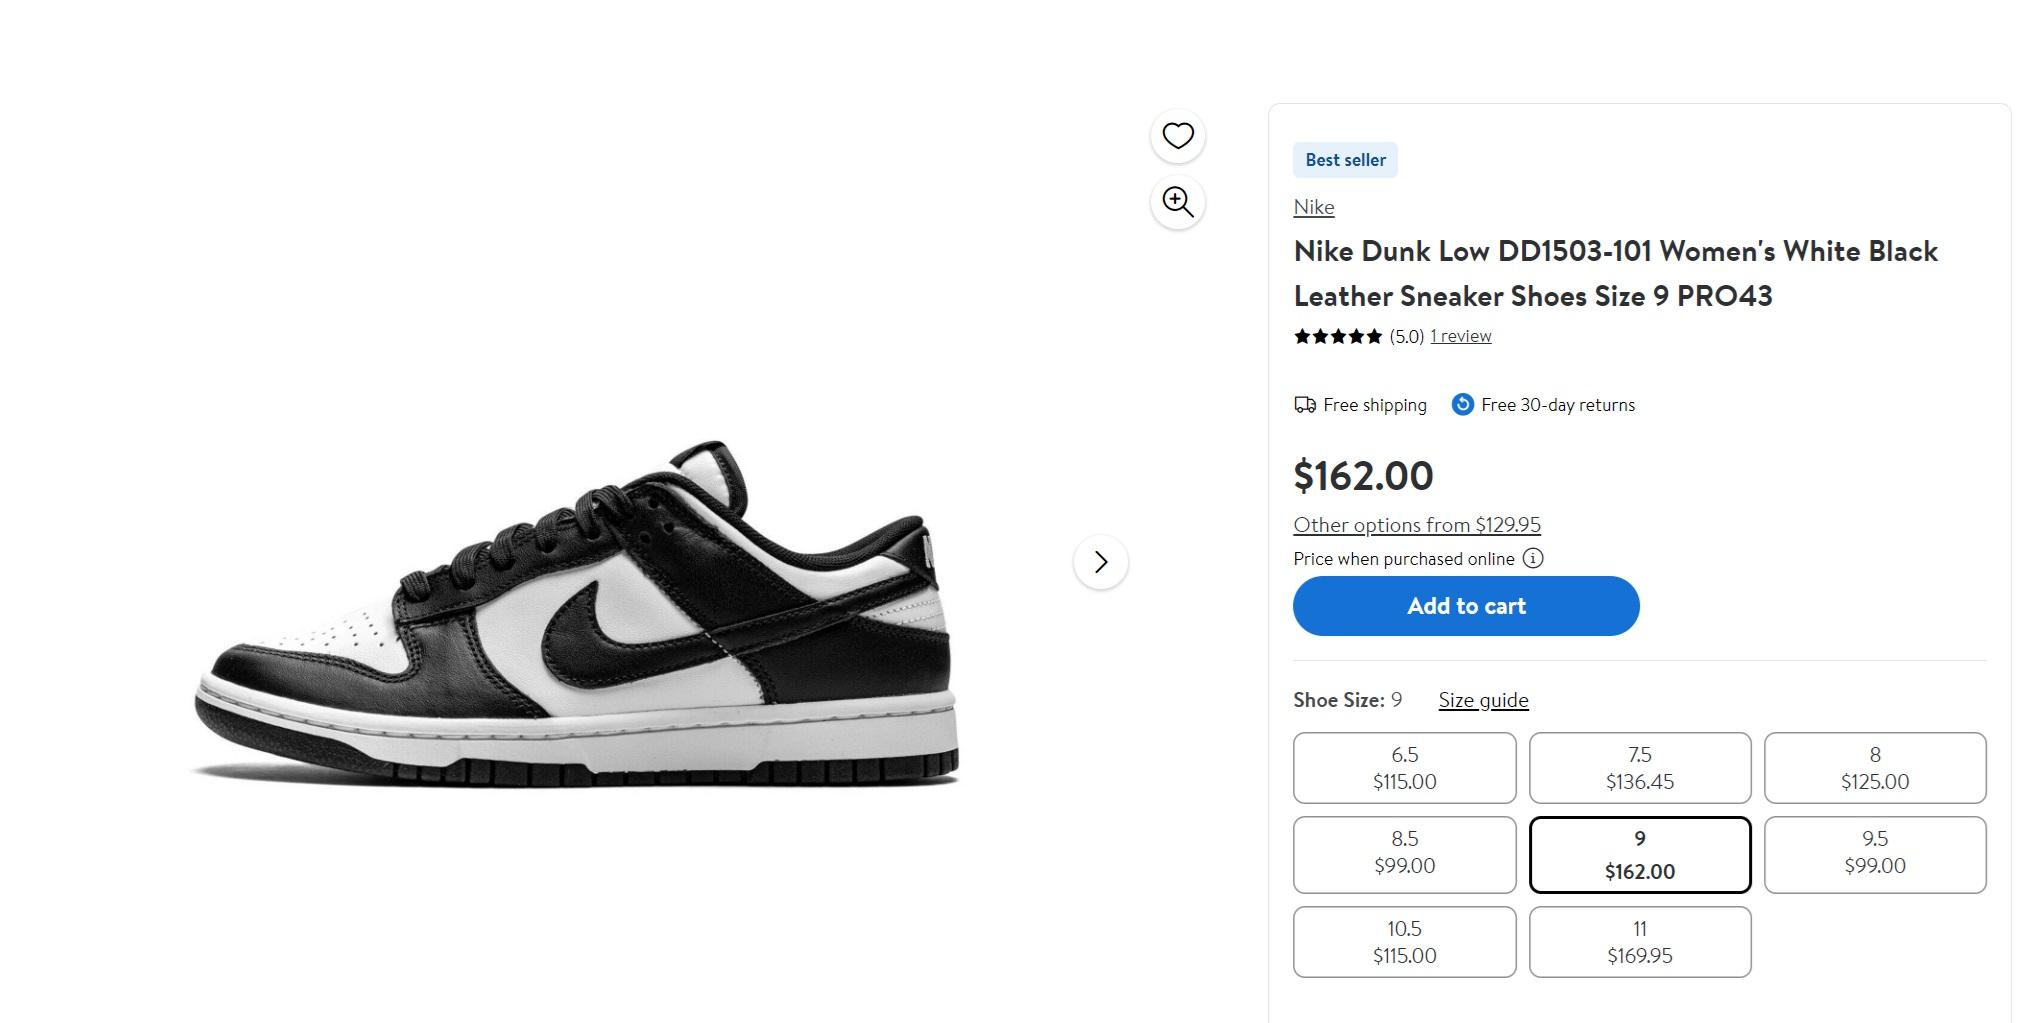

In [25]:
import wandb    
import os    
import torch    
from transformers import AutoModelForCausalLM, AutoProcessor    
from PIL import Image    
import requests    
from io import BytesIO    
import base64    
from pathlib import Path    
import weave  # Add this import  
  
# Initialize Weights & Biases run    
run = wandb.init(project='davidwei-phi3-v-test')    
  
# Use the artifact    
artifact = run.use_artifact('davidsajare/model-registry/davidwei-phi3-v:v0', type='model')    
artifact_dir = artifact.download()    
print(f"Artifact downloaded to: {artifact_dir}")    
  
model_id = "microsoft/Phi-3-vision-128k-instruct"    
  
try:    
    model = AutoModelForCausalLM.from_pretrained(    
        artifact_dir,     
        torch_dtype=torch.float16,     
        attn_implementation="flash_attention_2",    
        trust_remote_code=True    
    )    
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)    
except Exception as e:    
    print(f"Error loading model or processor: {e}")    
    raise    
  
# Ensure the model is on the correct device    
device = 'cuda'    
model.to(device)    
  
# Function to convert image to data URL    
EXT_TO_MIMETYPE = {    
    '.jpg': 'image/jpeg',    
    '.jpeg': 'image/jpeg',    
    '.png': 'image/png',    
    '.svg': 'image/svg+xml'    
}    
  
def image_to_data_url(image: Image.Image, ext: str) -> str:    
    ext = ext.lower()    
    if ext not in EXT_TO_MIMETYPE:    
        ext = '.jpg'  # Default to .jpg if extension is not recognized    
    mimetype = EXT_TO_MIMETYPE[ext]    
    buffered = BytesIO()    
    image_format = 'JPEG' if ext in ['.jpg', '.jpeg'] else ext.replace('.', '').upper()    
    image.save(buffered, format=image_format)    
    encoded_string = base64.b64encode(buffered.getvalue()).decode('utf-8')    
    data_url = f"data:{mimetype};base64,{encoded_string}"    
    return data_url    
  
# Function to run inference on a single image    
@weave.op()    
def run_inference(image_path_or_url: str) -> dict:    
    try:    
        prompt = "<|user|>\n<|image_1|>1.what is the price in 6.5? 2.What is the good?<|end|><|assistant|>\n"    
        #prompt = "<|user|>\n<|image_1|>what is image？<|end|><|assistant|>\n"    
        # Check if the input is a URL or a local file path  
        if image_path_or_url.startswith("http://") or image_path_or_url.startswith("https://"):  
            # Load image from URL  
            image = Image.open(requests.get(image_path_or_url, stream=True).raw)    
            ext = Path(image_path_or_url).suffix  
        else:  
            # Load image from local file path  
            image = Image.open(image_path_or_url)  
            ext = Path(image_path_or_url).suffix  
  
        # Convert image to data URL    
        data_url = image_to_data_url(image, ext)    
        inputs = processor(prompt, [image], return_tensors="pt").to(device)    
        generation_args = {     
            "max_new_tokens": 500,     
            "temperature": 0.0,     
            "do_sample": False,     
        }    
        generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)    
        # Remove input tokens    
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]    
        response_text = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]    
        return {    
            "predicted_text": response_text,    
            "image_data_url": data_url    
        }    
    except Exception as e:    
        print(f"Error during inference: {e}")    
        raise    
  
# Initialize Weave project    
weave.init('davidwei-phi3-v-test')    
  
# Example usage    
# For local image  
# image_path_or_url = "/path/to/your/local/image.jpg"  
# For URL image  
#image_path_or_url = "https://assets.burberry.com/is/image/Burberryltd/1C09D316-7A71-472C-8877-91CEFBDB268A?$BBY_V3_SL_1$&wid=1501&hei=1500"  
image_path_or_url = "/root/5.jpg"  
try:    
    result = run_inference(image_path_or_url)    
    print("Predicted Text:", result['predicted_text'])    
    print("Image Data URL:", result['image_data_url'])    
except Exception as e:    
    print(f"Error running inference: {e}")    


In [6]:
!pwd

/root


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
!ls -al /root/2.jpg

-rw------- 1 root root 75327 Jun  1 09:48 /root/2.jpg


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
